# Treatment of uncomplicated UTIs in primary care

### Obtaining data from BigQuery

In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import  DateFormatter
import datetime
import matplotlib.gridspec as gridspec
%matplotlib inline
from matplotlib import rcParams

projectid = "ebmdatalab"


In [3]:
#obtain overall data for prescribing for trimethoprim capsules at CCG level
ccg_df = pd.read_gbq("""
SELECT
  trimethoprim.month as period,
  trimethoprim.pct,
  SUM(CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
      ELSE 0 END) AS trimethoprim_items,
  SUM(CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501130R0' THEN items
      ELSE 0 END) AS nitrofurantoin_items,
  SUM(items) AS all_items,
  IEEE_DIVIDE(SUM(
      CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
        ELSE 0 END), SUM(items)) AS trimethoprim_percent
FROM
ebmdatalab.richard.trimethoprim_data AS trimethoprim
INNER JOIN
  ebmdatalab.hscic.ccgs AS ccg
ON
  trimethoprim.pct=ccg.code
WHERE
 ccg.org_type = 'CCG'
and trimethoprim.month  >='2011-01-01 00:00:00'
GROUP BY
  period,
  pct
ORDER BY
  period,
  pct
""", projectid, dialect='standard')


In [4]:
#obtain overall data for prescribing for trimethoprim at practice level where practices with list size of => 1000
practice_df = pd.read_gbq("""
SELECT
  trimethoprim.month as period,
  trimethoprim.practice,
  SUM(CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
      ELSE 0 END) AS trimethoprim_items,
  SUM(CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501130R0' THEN items
      ELSE 0 END) AS nitrofurantoin_items,
  SUM(items) AS all_items,
  IEEE_DIVIDE(SUM(
      CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
        ELSE 0 END), SUM(items)) AS trimethoprim_percent
FROM
  ebmdatalab.richard.trimethoprim_data AS trimethoprim
INNER JOIN
  ebmdatalab.hscic.practice_statistics_all_years AS listsize
ON
  trimethoprim.practice=listsize.practice
AND   
  trimethoprim.month=listsize.month
WHERE
  listsize.total_list_size >=1000
  and trimethoprim.month >='2011-01-01 00:00:00'
GROUP BY
  period,
  practice
ORDER BY
  period,
  practice
""", projectid, dialect='standard')


### Create timeseries for CCGs and practice deciles of percentage of UTI prescribing as trimethoprim

In [5]:
#create deciles for practices
x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))
practice_deciles = practice_df.groupby('period')['trimethoprim_percent'].quantile(x)
practice_deciles_df=pd.DataFrame(practice_deciles)
practice_deciles_df=practice_deciles_df.reset_index()
# create integer range of percentiles as integers are better for  charts
practice_deciles_df["index"] = (practice_deciles_df.level_1*100).map(int)
practice_deciles_df['period'] = practice_deciles_df['period'].astype(str)
# set format for dates:
practice_deciles_df['period'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in practice_deciles_df['period']]

#create deciles for CCGs
x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))
ccg_deciles = ccg_df.groupby('period')['trimethoprim_percent'].quantile(x)
ccg_deciles_df=pd.DataFrame(ccg_deciles)
ccg_deciles_df=ccg_deciles_df.reset_index()
# create integer range of percentiles as integers are better for  charts
ccg_deciles_df["index"] = (ccg_deciles_df.level_1*100).map(int)
ccg_deciles_df['period'] = ccg_deciles_df['period'].astype(str)
# set format for dates:
ccg_deciles_df['period'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in ccg_deciles_df['period']]

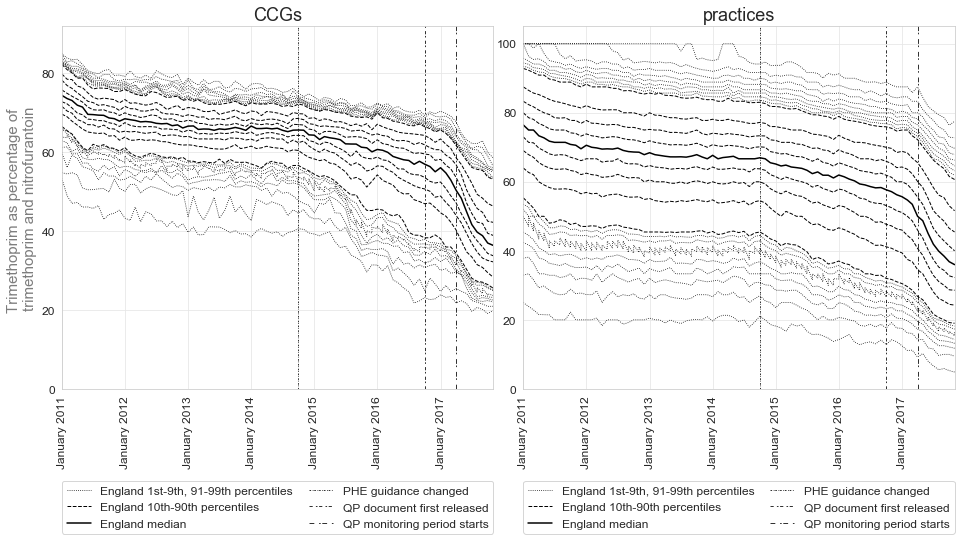

In [6]:
sns.set_style("whitegrid",{'grid.color': '.9'})
fig = plt.figure(figsize=(16,6.666)) 
gs = gridspec.GridSpec(1,2)  # grid layout for subplots

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,ccg_deciles_df,0,0,'CCGs'), (1,practice_deciles_df,0,1,'practices')]

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s (, sharey=ax)
    for decile in range(1,99):   # plot each decile line
        data = i[1].loc[(i[1]['index']==decile)]
        if decile == 50:
            ax.plot(data["period"],100*data['trimethoprim_percent'],'b-',linewidth=1.5, color='k', label='England median')
        if decile == 10:
            ax.plot(data["period"],100*data['trimethoprim_percent'],'b--',linewidth=1,color='k',label='England 10th-90th percentiles') 
        if (decile == 1) :
            ax.plot(data["period"],100*data['trimethoprim_percent'],'b:',linewidth=.8, color='k',label='England 1st-9th, 91-99th percentiles')
        if ((decile <10) and (decile >1)) | (decile >90):
            ax.plot(data["period"],100*data['trimethoprim_percent'],'b:',linewidth=.8, color='k',label='_nolegend_')
        if (decile >10) and (decile <91) and (decile !=50):
            ax.plot(data["period"],100*data['trimethoprim_percent'],'b--',linewidth=1,color='k', label='_nolegend_') 
    if  i[3]%2==0:    # set y axis title only for charts in leftmost column
        ax.set_ylabel('Trimethoprim as percentage of \ntrimethoprim and nitrofurantoin', size =15, alpha=0.6)
        
       
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, 100*i[1]['trimethoprim_percent'].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([i[1]['period'].min(), i[1]['period'].max()]) # set x axis range as full date range
    ax.axvline(x='2014-10-01',label='PHE guidance changed', linewidth=.8, dashes = (2,2,1,1), color='k')
    ax.axvline(x='2016-10-01',label='QP document first released', linewidth=.8, dashes = (4,4,2,2), color='k')
    ax.axvline(x='2017-04-01',label='QP monitoring period starts', linewidth=.8, dashes = (6,6,2,2), color='k')

    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%B %Y'))
    ax.legend(bbox_to_anchor=(0., -.4, 1., .102), loc=8,
       ncol=2, mode="expand", fontsize=12, borderaxespad=0.)

    
plt.subplots_adjust(wspace = 0.07,hspace = 0.15)
plt.savefig('Figure 1.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

In [7]:
#obtain overall data for prescribing for trimethoprim for three time periods
ccg_map_df = pd.read_gbq("""
SELECT
  trimethoprim.pct,
  IEEE_DIVIDE(
  SUM(CASE
      WHEN (SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0') AND (trimethoprim.month >='2014-04-01 00:00:00' AND trimethoprim.month <= '2014-09-01 00:00:00')THEN items
      ELSE 0 END),
  SUM(CASE
      WHEN (trimethoprim.month >='2014-04-01 00:00:00' AND trimethoprim.month <= '2014-09-01 00:00:00')THEN items
      ELSE 0 END))*100 as ccg_pre,
  IEEE_DIVIDE(
  SUM(CASE
      WHEN (SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0') AND (trimethoprim.month >='2014-10-01 00:00:00' and trimethoprim.month <= '2015-03-01 00:00:00')THEN items
      ELSE 0 END),
  SUM(CASE
      WHEN (trimethoprim.month >='2014-10-01 00:00:00' and trimethoprim.month <= '2015-03-01 00:00:00')THEN items
      ELSE 0 END))*100 as ccg_post,
  IEEE_DIVIDE(
  SUM(CASE
      WHEN (SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0') AND (trimethoprim.month >='2017-04-01 00:00:00' and trimethoprim.month <= '2017-09-01 00:00:00')THEN items
      ELSE 0 END),
  SUM(CASE
      WHEN (trimethoprim.month >='2017-04-01 00:00:00' and trimethoprim.month <= '2017-09-01 00:00:00')THEN items
      ELSE 0 END))*100 as ccg_qp      
FROM
  ebmdatalab.richard.trimethoprim_data AS trimethoprim
INNER JOIN
  ebmdatalab.hscic.ccgs AS ccg
ON
  trimethoprim.pct=ccg.code
WHERE
  ccg.org_type = 'CCG'
GROUP BY
  pct
ORDER BY
  pct
""", projectid, dialect='standard')
ccg_map_df.to_csv('ccg_map_df.csv')

In [8]:
# join to geographical data
map_data = ccg_map_df.reset_index()
names = pd.read_csv('ccg_for_map.csv')
map_data = map_data.merge(names[['code','name', 'is_london']],left_on="pct",right_on="code")
map_data['name'] = map_data['name'].str.upper()
map_data['name'] = map_data["name"].str.replace("&","AND")
map_data = map_data.set_index('name')
map_data.to_csv('map_data.csv')

In [9]:
import geopandas as gpd
from matplotlib import verbose

ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf= ccgs.join(map_data)
is_london =  gdf['is_london']==True
gdf_london = gdf[is_london]
is_london =  gdf['is_london']==False
gdf_roe = gdf[is_london]

ModuleNotFoundError: No module named 'geopandas'

In [ ]:
# set sort order of measures manually, and add grid refs to position each subplot:

s_pre_roe = [(0,'ccg_pre',0,0)]
s_post_roe = [(1,'ccg_post',0,1)]
s_qp_roe = [(2,'ccg_qp',0,2)]
s_pre_london = [(0,'ccg_pre',1,0)]
s_post_london = [(1,'ccg_post',1,1)]
s_qp_london = [(2,'ccg_qp',1,2)]

# set common value limits for colour scale
vmin, vmax = 20, 85
edgecolor = 'black'
linewidth = 0.1
cmap = 'OrRd'

fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(2,3, width_ratios=[4,4,5])  # grid layout for subplots


for i in s_pre_roe:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf_roe.plot(ax=ax,column=i[1], edgecolor=edgecolor, linewidth=linewidth, legend=False, cmap=cmap ,vmin=vmin, vmax=vmax)
    ax.set_aspect(1.63)
    ax.set_title("England(excluding London):\n\nBefore amended PHE guidance \n(April-September 2014) ",size = 14)
    plt.axis('off')
for i in s_post_roe:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf_roe.plot(ax=ax,column=i[1], edgecolor=edgecolor, linewidth=linewidth, legend=False, cmap=cmap ,vmin=vmin, vmax=vmax)
    ax.set_aspect(1.63)
    ax.set_title('\n\nAfter amended PHE guidance \n(October 2014-March 2015)', size=14)
    plt.axis('off')
for i in s_qp_roe:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf_roe.plot(ax=ax,column=i[1], edgecolor=edgecolor, linewidth=linewidth, legend=False, cmap=cmap ,vmin=vmin, vmax=vmax)
    ax.set_aspect(1.63)
    ax.set_title("\n\nQuality Premium \n(April-September 2017)",size = 14)
    plt.axis('off')
for i in s_pre_london:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf_london.plot(ax=ax,column=i[1], edgecolor=edgecolor, linewidth=linewidth, legend=False, cmap=cmap ,vmin=vmin, vmax=vmax)
    ax.set_aspect(1.63)
    ax.set_title("London:",size = 14)
    plt.axis('off')
for i in s_post_london:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf_london.plot(ax=ax,column=i[1], edgecolor=edgecolor, linewidth=linewidth, legend=False, cmap=cmap ,vmin=vmin, vmax=vmax)
    ax.set_aspect(1.63)
    plt.axis('off')
for i in s_qp_london:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf_london.plot(ax=ax,column=i[1], edgecolor=edgecolor, linewidth=linewidth, legend=True, cmap=cmap ,vmin=vmin, vmax=vmax)
    ax.set_aspect(1.63)
    plt.axis('off')
plt.subplots_adjust(wspace = 0.05,hspace = 0.05)
plt.savefig('Figure 3.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

### Top 10 highest and lowest users

In [ ]:
#obtain data for lowest and highest 10 CCG prescribers of trimethoprim
high_low_df = pd.read_gbq("""
SELECT
  month,
  IEEE_DIVIDE(SUM(
      CASE
        WHEN SUBSTR(trimeth.bnf_code,1,9)='0501080W0' and high_low.high_low = 'lowest' THEN items
        ELSE 0 END),
       SUM(CASE
        WHEN high_low.high_low = 'lowest' THEN items
        ELSE 0 END))*100 AS lowest_10_trimeth_percent,
  IEEE_DIVIDE(SUM(
      CASE
        WHEN SUBSTR(trimeth.bnf_code,1,9)='0501080W0' and high_low.high_low = 'highest' THEN items
        ELSE 0 END),
       SUM(CASE
        WHEN high_low.high_low = 'highest' THEN items
        ELSE 0 END))*100 AS highest_10_trimeth_percent
FROM
  `ebmdatalab.richard.trimethoprim_data` AS trimeth
  join
  `ebmdatalab.richard.trimethoprim_high_low` as high_low
  on
  trimeth.pct = high_low.ccg
WHERE
  month>='2014-01-01'
GROUP BY
  month
ORDER BY
  month
  """, projectid, dialect='standard')
high_low_df.to_csv('high_low_df.csv')

In [ ]:
#plot data for both, and include vertical lines for key dates
sns.set_style("whitegrid",{'grid.color': '.9'})
sns.set_context({"figure.figsize": (24, 10)})
fig = plt.figure
f, (ax1) = plt.subplots(1,1)
ax1.plot('month','lowest_10_trimeth_percent', data=high_low_df, label='Lowest 10 CCGs',color='k', marker='o')
ax1.plot('month','highest_10_trimeth_percent', data=high_low_df, label='Highest 10 CCGs', color='k', marker='^')
ax1.axvline(x='2014-10-01',label='PHE guidance changed', dashes = (2,2,1,1), color='k')
ax1.axvline(x='2016-10-01',label='QP document first released', dashes = (4,4,2,2), color='k')
ax1.axvline(x='2017-04-01',label='QP monitoring period starts', dashes = (6,6,2,2), color='k')
ax1.set_ylim(ymin=0)
ax1.set_xlim(xmax='2017-12-01')
ax1.legend(bbox_to_anchor=(0., -.4, 1., .102), loc=8,
       ncol=2, mode="expand", fontsize=16, borderaxespad=0.)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)

ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%B %Y'))

plt.savefig('Figure 4.png', format='png', dpi=300,bbox_inches='tight')